In [21]:
import matplotlib.pyplot as plt
import tempfile
import subprocess
import os
import json
from types import SimpleNamespace
from statistics import harmonic_mean

CWD = os.getcwd()
NS_PER_US = 1e3
print(f'Running in {CWD}.. this should be the project root folder!')

Running in /Users/wojtek/Programming/Lean/groupoid_model_in_lean4.. this should be the project root folder!


In [22]:
def measure(samplerMod, sampleCmd, constNm, dataFile):
  with tempfile.NamedTemporaryFile(mode='w', suffix='.lean', encoding='utf-8') as f:
    f.write(f'''
      import bench.samplers.{samplerMod}
      import bench.measure
      set_option maxHeartbeats 0
      {sampleCmd}
      #measure {constNm} "{dataFile}" 0
    ''')
    f.flush()
    subprocess.run(["lake", "lean", f.name], cwd=CWD)

In [23]:
N = 50
for i in range(N):
  # Measure the timing for each definition in a separate Lean process
  # to eliminate any potential cross-definition caching.
  measure('fn', f'#sample_fns {N}', f'benchDef_fn_{i}', 'times_id.ndjson')

⚠ [303/311] Replayed GroupoidModel.Syntax.Typechecker.Evaluate
✔ [310/311] Built bench.measure
⚠ [303/311] Replayed GroupoidModel.Syntax.Typechecker.Evaluate
⚠ [303/311] Replayed GroupoidModel.Syntax.Typechecker.Evaluate
⚠ [303/311] Replayed GroupoidModel.Syntax.Typechecker.Evaluate
⚠ [303/311] Replayed GroupoidModel.Syntax.Typechecker.Evaluate
⚠ [303/311] Replayed GroupoidModel.Syntax.Typechecker.Evaluate
⚠ [303/311] Replayed GroupoidModel.Syntax.Typechecker.Evaluate
⚠ [303/311] Replayed GroupoidModel.Syntax.Typechecker.Evaluate
⚠ [303/311] Replayed GroupoidModel.Syntax.Typechecker.Evaluate
⚠ [303/311] Replayed GroupoidModel.Syntax.Typechecker.Evaluate
⚠ [303/311] Replayed GroupoidModel.Syntax.Typechecker.Evaluate
⚠ [303/311] Replayed GroupoidModel.Syntax.Typechecker.Evaluate
⚠ [303/311] Replayed GroupoidModel.Syntax.Typechecker.Evaluate
⚠ [303/311] Replayed GroupoidModel.Syntax.Typechecker.Evaluate
⚠ [303/311] Replayed GroupoidModel.Syntax.Typechecker.Evaluate
⚠ [303/311] Replayed Gr

In [24]:
data = {}
with open('times_id.ndjson', 'r') as f:
  for line in f:
    obj = json.loads(line, object_hook=lambda d: SimpleNamespace(**d))
    # Prefers latest data when seeing multiple entries for the same definition
    data[obj.name] = obj

In [32]:
xs = [ ob.sz for ob in data.values() ]
ys = [ ob.t_kernel for ob in data.values() ]
rys = [ ob.t_translate + ob.t_typecheck + ob.t_rkernel for ob in data.values() ]
(xs, ys, rys) = zip(*sorted(zip(xs, ys, rys)))

print(f'Average overhead: {harmonic_mean([ry/y for (ry, y) in zip(rys, ys)])}')

Average overhead: 1043.9287484771817


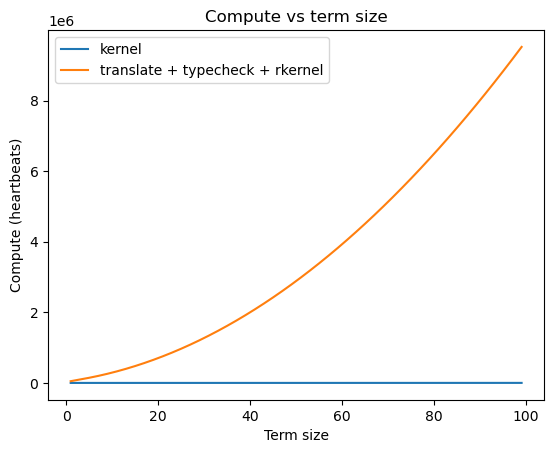

In [34]:
fig, ax = plt.subplots()

ax.set_title("Compute vs term size")
ax.set_xlabel("Term size")
ax.set_ylabel("Compute (heartbeats)")

ax.plot(xs, ys, label="kernel")
ax.plot(xs, rys, label="translate + typecheck + rkernel")
ax.legend()


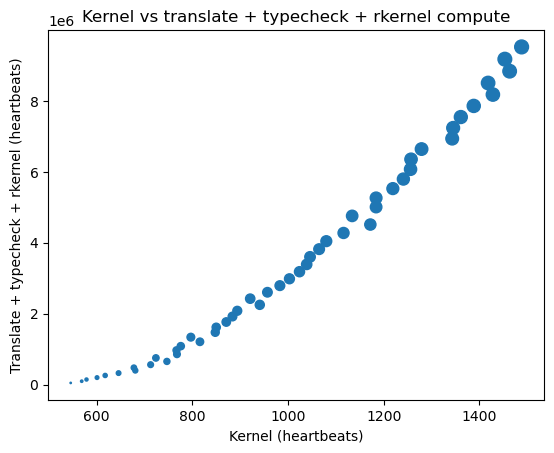

In [43]:
fig, ax = plt.subplots()

ax.set_title("Kernel vs translate + typecheck + rkernel compute")
ax.set_xlabel("Kernel (heartbeats)")
ax.set_ylabel("Translate + typecheck + rkernel (heartbeats)")

ax.scatter(ys, rys, s=xs)